Since a lot of my noise data only covers frequencies up to 3kHz, and this is not enough for shot noise data, I'm going to look at some 1/f noise.

In [938]:
%matplotlib inline
import matplotlib as mpl
mpl.style.use('/Users/nik/Dropbox/Notebooks/thesisrc.py')
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import glob
import os
import pandas as pd
import lvdatatools as lvdt
import re
import math

# SCF72

In [939]:
pkl_dir = '/Volumes/JUPITER/Data/fm_dots/SCF72/'

In [940]:
def get_dIdV(df, dV):
    return pd.DataFrame(np.gradient(df,dV)[0], index = df.index, columns = df.columns)

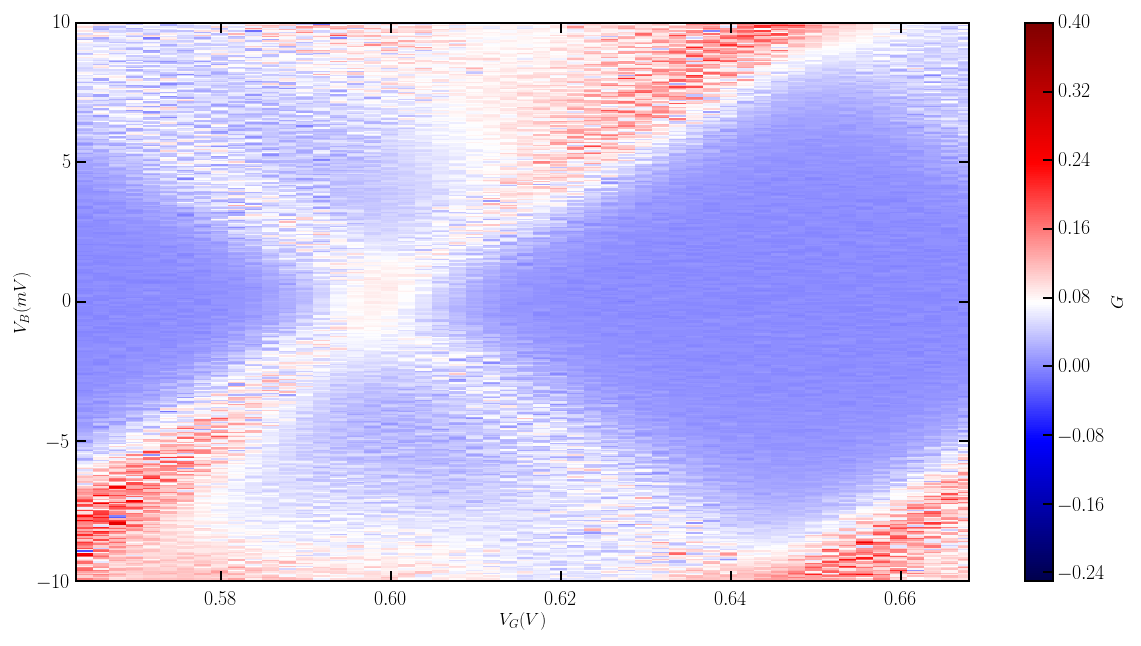

In [948]:
f = os.path.join(pkl_dir, '4K_VI-gate_17-19_13_g_cond.pkl')
cond = pd.read_pickle(f)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
limits = lvdt.df_extent(cond)
im = ax.imshow(cond/3.875e-5, extent = limits, 
               cmap = plt.cm.seismic, vmin = -0.25, vmax = 0.4, 
               origin = 'lower', aspect = 'auto', interpolation = 'nearest')
ax.set_xlabel(r'$V_G (V)$')
ax.set_ylabel(r'$V_B (mV)$')
ax.set_xlim(0.563, 0.668)
cb = plt.colorbar(im)
cb.set_label(r'$G$')

Alright. That's the data set I'm working with. Going to grab one of the gate sweep files and try to make some time series plots.

In [949]:
reload(lvdt)

<module 'lvdatatools' from '/Users/nik/Dropbox/Repos/lvdatatools/lvdatatools.pyc'>

In [950]:
def get_data_ps(filename):
    """ returns a pandas array with the 2d data from the binary file
        tagged with relevant information from the header file """
    
    
    df = lvdt.get_data_2d(filename) # get data
    df['Bias'] *= 1000.0
    
    dt = df['dt'].mean()
    M, N = df.ix[:,'i0':].shape
    t = np.arange(0,N)*dt # time series (s)
    freqs = np.fft.fftfreq(N, dt) # frequency (Hz)
    idx = np.argsort(freqs) # sort arrays with this
    freqs = freqs[idx]
    
    # get the white noise spectrum
    white = np.zeros(N)
    i = 0.0
    for s in df[np.abs(df['Bias'])<1e-6].ix[:,'i0':].values:
        white += np.abs(np.fft.fft(s))**2
        i +=1.0
    white = white[idx]/i
    
    # setup dataframe
    cols = ['Bias', 'Iavg']
    cols.extend([f for f in freqs[N/2:]])
    psdf = pd.DataFrame(np.zeros((M,N/2+2)), columns = cols)
    psdf[['Bias','Iavg']] = df[['Bias','Iavg']]
    for j, s in enumerate(df.ix[:,'i0':].values):
        ps = np.abs(np.fft.fft(s))**2
        psdf.iloc[j,2:] = ps[idx][N/2:] - white[N/2:]
    return psdf.groupby(psdf['Bias']).mean()

In [1007]:
f = '/Volumes/JUPITER/Data/SCF72/4K/VI-gate_17-19_13_g_600.bin'
psdf = get_data_ps(f)

current = psdf['Iavg']
psdf.drop(psdf.columns[[0, 1]], axis=1, inplace=True) # drop the current and f=0 columns

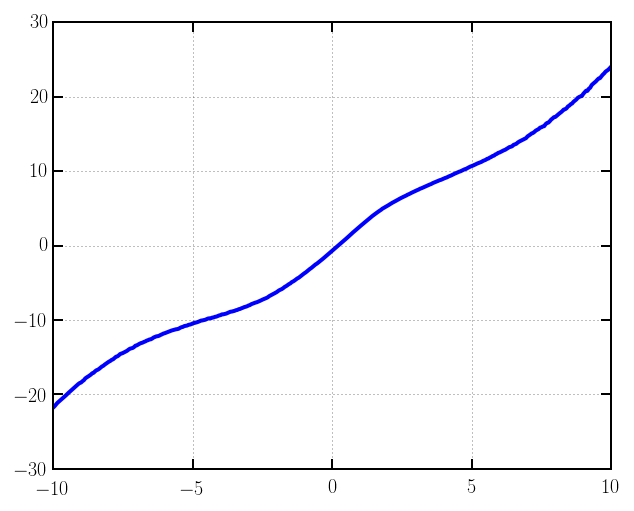

In [1008]:
fig, ax = plt.subplots(1, 1)
ax.plot(current.index, current*1e9)
ax.grid()

Great. Now I know how to get all of the data. How do I fit each bias row to $S = \frac{A I^2}{f}$ ?

In [1168]:
def noise_model(x, amp, z, current):
    return amp*(current**2)/np.power(x, z)

In [1179]:
from lmfit import Model, Parameter

model = Model(noise_model, independent_vars=['x'])
params = model.make_params()
params['current'].vary = False
params['amp'].min = 0.0
params['amp'].value = 1.0
params['z'].vary = False
params['z'].value = 1.0

In [1191]:
f = '/Volumes/JUPITER/Data/SCF72/4K/VI-gate_17-19_13_g_640.bin'

psdf = get_data_ps(f)
current = psdf['Iavg']
psdf.drop(psdf.columns[[0, 1]], axis=1, inplace=True) # drop the current and f=0 columns

A = np.zeros(len(psdf.index))
for i, bias in enumerate(psdf.index):
    # if not np.abs(current[bias]*1e9) < 1e-1:
    params['current'].value = (current[bias]*1e9) # rescale current to avoid float problems
    result = model.fit(psdf.loc[bias,:], params, x=psdf.columns)
    A[i] = result.params['amp'].value # rescale to correct units

3104.44445387


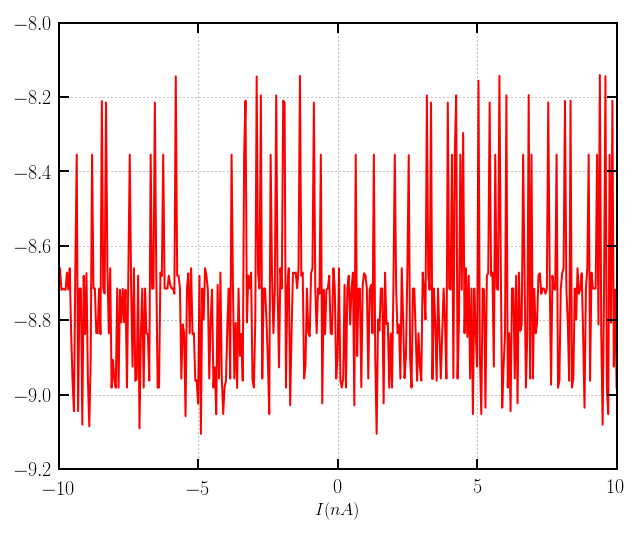

In [1192]:
bias = 5.6

params['current'].value = current[bias]
result = model.fit(psdf.loc[bias,:], params, x=psdf.columns)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(psdf.index, np.log10(A), 'r', lw=2)
ax.set_xlabel('$I (nA)$')
#ax.plot(psdf.columns.values, psdf.loc[bias, :], '.', ms = 2)
#ax.plot(psdf.columns.values, noise_model(psdf.columns, **result.params))
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.plot()
ax.grid()
#ax.set_xlim(-1e-8, 1e-8)

print result.params['amp'].value

Cool. Now do it for the whole data set.

In [1100]:
pkl_dir = '/Volumes/JUPITER/Data/fm_dots/SCF72/'
cold_dir = '/Volumes/JUPITER/Data/SCF72/4K/'
fig_dir = '/Volumes/JUPITER/Data/fm_dots/SCF72/figures/'

In [1056]:
# header = lvdt.get_txt(os.path.join(cold_dir, 'VI-gate_17-19_13_g.txt'))
# for h in header:
#     print h

In [1101]:
start = 0.3; stop = 0.8; step = 2e-3
gate = np.arange(start,stop+step, step)
filelist = [os.path.join(cold_dir, 'VI-gate_17-19_13_g_{0:.0f}.bin'.format(g*1000)) for g in gate]

In [1184]:
# ### get full data set to create empty arrays ###
full_data_set = os.path.join(pkl_dir, '4K_VI-gate_17-19_13_g.pkl')
df = pd.read_pickle(full_data_set)
df = df.groupby(df.index).mean()
offset = df.loc[0.0, :].mean()
ampdf = pd.DataFrame(np.zeros(df.shape), index = df.index, columns = df.columns)

for j, f in enumerate(filelist):
    psdf = get_data_ps(f)

    current = psdf['Iavg'] - offset
    psdf.drop(psdf.columns[[0, 1]], axis=1, inplace=True) # drop the current and f=0 columns

    #A = np.zeros(len(df.index))
    for i, bias in enumerate(df.index):
        params['current'].value = current[bias] # set current
        result = model.fit(psdf.ix[bias,:], params, x=psdf.columns)
        ampdf.iloc[i,j] = result.params['amp'].value

In [267]:
# ampdf.to_pickle(os.path.join(pkl_dir, '4K_VI-gate_17-19_13_g_noise-amp.pkl'))

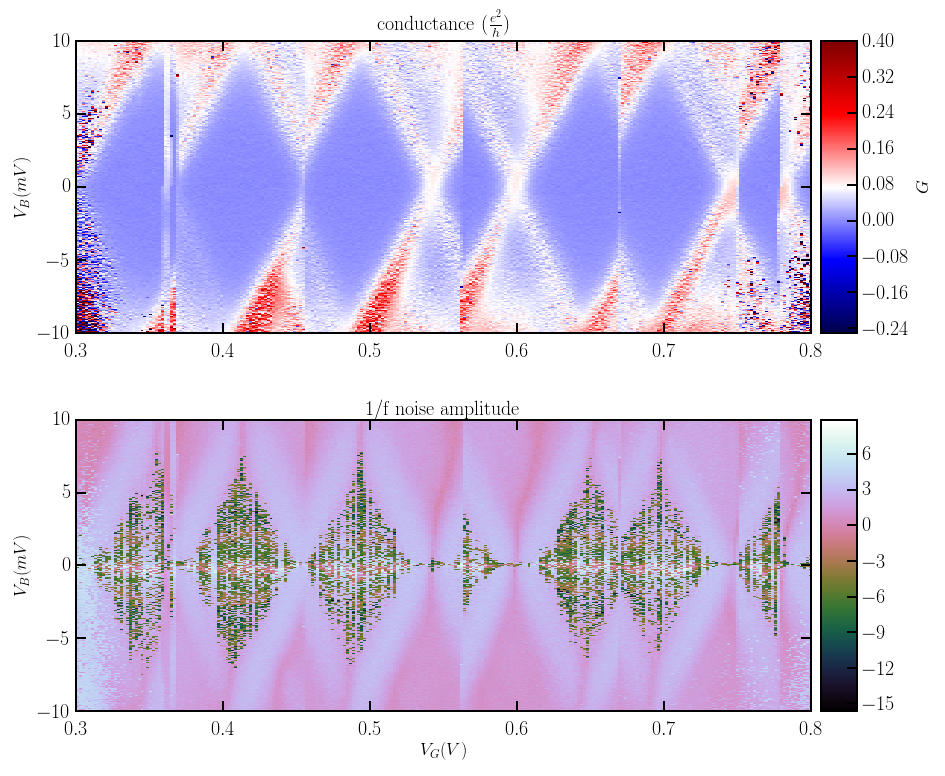

In [1185]:
cond = pd.read_pickle(os.path.join(pkl_dir, '4K_VI-gate_17-19_13_g_cond.pkl'))
# ampdf = pd.read_pickle(os.path.join(pkl_dir, '4K_VI-gate_17-19_13_g_noise-amp.pkl'))                    

fig = plt.figure(figsize = (14,12))
gs = gridspec.GridSpec(2, 2, height_ratios=(1, 1), width_ratios=(20, 1))
gs.update(wspace=0.025, hspace=0.3)
axes = fig.add_subplot(gs[0,0])
limits = lvdt.df_extent(ampdf)

im0 = axes.imshow(cond/3.875e-5, extent = limits, 
               cmap = plt.cm.seismic, vmin = -0.25, vmax = 0.4, 
               origin = 'lower', aspect = 'auto', interpolation = 'nearest')
#ax[0].set_xlabel(r'$V_G (V)$')
axes.set_ylabel(r'$V_B (mV)$')
axes.set_title(r'conductance ($\frac{e^2}{h}$)')
cax = fig.add_subplot(gs[0,1])
cb0 = plt.colorbar(im0, cax = cax)
cb0.set_label(r'$G$')

axes = fig.add_subplot(gs[1,0])
im1 = axes.imshow(np.log10(ampdf), extent = limits, 
               cmap = plt.cm.cubehelix, #vmin = 1, vmax = 5, 
               origin = 'lower', aspect = 'auto', interpolation = 'nearest')
axes.set_xlabel(r'$V_G (V)$')
axes.set_ylabel(r'$V_B (mV)$')
axes.set_title('1/f noise amplitude')
cax = fig.add_subplot(gs[1,1])
cb1 = plt.colorbar(im1, cax = cax)
# cb1.set_label(r'$\log_{10}(A)$')

# fig.savefig(os.path.join(fig_dir, '4K_VI-gate_17-19_13_g_cond-noise.pdf'), format='pdf', dpi=300)

In [ ]:
#### f = os.path.join(pkl_dir, '4K_VI-gate_17-19_13_g_n4T.pkl')
# df = pd.read_pickle(f)

# dV = 50e-6
# cond = get_dIdV(df,dV)

# fig = plt.figure(figsize=(20,10))
# ax = fig.add_subplot(1,1,1)
# limits = lvdt.df_extent(cond)
# im = ax.imshow(cond/3.875e-5, extent = limits, 
#                cmap = plt.cm.seismic, vmin = -0.25, vmax = 0.4, 
#                origin = 'lower', aspect = 'auto', interpolation = 'nearest')
# ax.set_xlabel(r'$V_G (V)$')
# ax.set_ylabel(r'$V_B (mV)$')
# cb = plt.colorbar(im)
# cb.set_label(r'$G$')

# cond.to_pickle(os.path.join(pkl_dir, '4K_VI-gate_17-19_13_g_n4T_cond.pkl'))

In [270]:
# header = lvdt.get_txt(os.path.join(cold_dir, 'VI-gate_17-19_13_g_n4T.txt'))
# for h in header:
#     print h

In [271]:
# start = 0.3; stop = 0.8; step = 2e-3
# gate = np.arange(start,stop+step, step)
# filelist = [os.path.join(cold_dir, 'VI-gate_17-19_13_g_n4T_{0:.0f}.bin'.format(g*1000)) for g in gate]

In [272]:
### get full data set to create empty arrays ###
# full_data_set = os.path.join(pkl_dir, '4K_VI-gate_17-19_13_g_n4T.pkl')
# df = pd.read_pickle(full_data_set)
# df = df.groupby(df.index).mean()
# ampdf = pd.DataFrame(np.zeros(df.shape), index = df.index, columns = df.columns)

# for j, f in enumerate(filelist):
#     psdf = get_data_ps(f)

#     current = psdf['Iavg']
#     psdf.drop(psdf.columns[[0, 1]], axis=1, inplace=True) # drop the current and f=0 columns

#     #A = np.zeros(len(df.index))
#     for i, bias in enumerate(df.index):
#         params['current'].value = current[bias] # set current
#         result = model.fit(psdf.ix[bias,:], params, x=psdf.columns)
#         ampdf.iloc[i,j] = result.params['amp'].value

In [273]:
# ampdf.to_pickle(os.path.join(pkl_dir, '4K_VI-gate_17-19_13_g_n4T_noise-amp.pkl'))

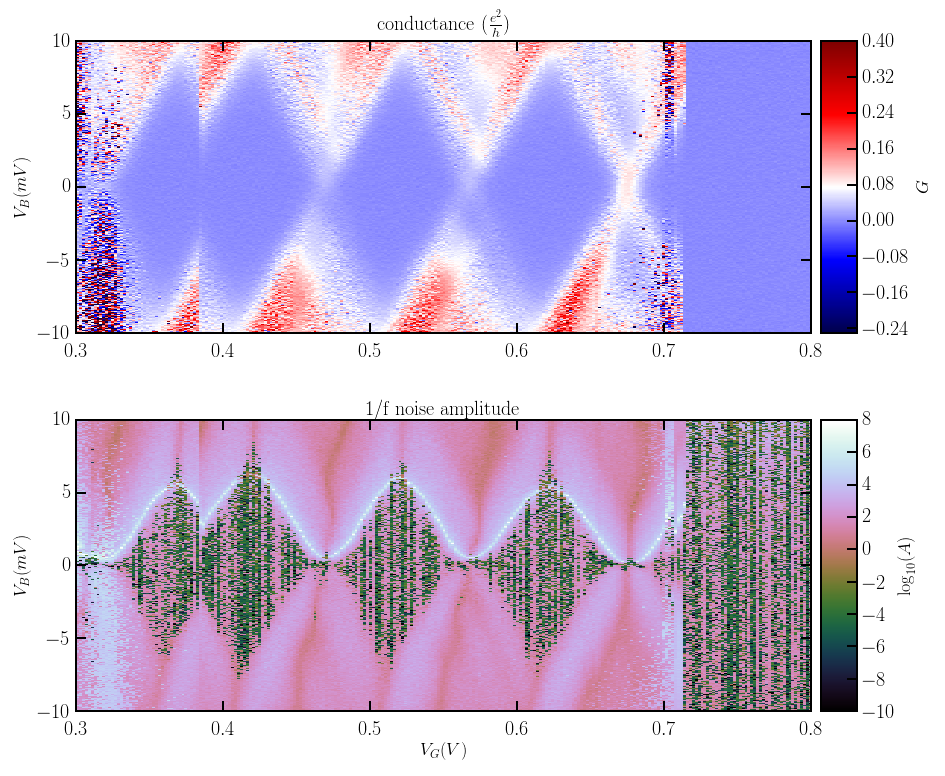

In [314]:
cond = pd.read_pickle(os.path.join(pkl_dir, '4K_VI-gate_17-19_13_g_n4T_cond.pkl'))
ampdf = pd.read_pickle(os.path.join(pkl_dir, '4K_VI-gate_17-19_13_g_n4T_noise-amp.pkl'))

fig = plt.figure(figsize = (14,12))
gs = gridspec.GridSpec(2, 2, height_ratios=(1, 1), width_ratios=(20, 1))
gs.update(wspace=0.025, hspace=0.3)
axes = fig.add_subplot(gs[0,0])
limits = lvdt.df_extent(ampdf)

im0 = axes.imshow(cond/3.875e-5, extent = limits, 
               cmap = plt.cm.seismic, vmin = -0.25, vmax = 0.4, 
               origin = 'lower', aspect = 'auto', interpolation = 'nearest')
#ax[0].set_xlabel(r'$V_G (V)$')
axes.set_ylabel(r'$V_B (mV)$')
axes.set_title(r'conductance ($\frac{e^2}{h}$)')
cax = fig.add_subplot(gs[0,1])
cb0 = plt.colorbar(im0, cax = cax)
cb0.set_label(r'$G$')

axes = fig.add_subplot(gs[1,0])
im1 = axes.imshow(np.log10(ampdf), extent = limits, 
               cmap = plt.cm.cubehelix, vmin = -10, vmax = 8, 
               origin = 'lower', aspect = 'auto', interpolation = 'nearest')
axes.set_xlabel(r'$V_G (V)$')
axes.set_ylabel(r'$V_B (mV)$')
axes.set_title('1/f noise amplitude')
cax = fig.add_subplot(gs[1,1])
cb1 = plt.colorbar(im1, cax = cax)
cb1.set_label(r'$\log_{10}(A)$')

fig.savefig(os.path.join(fig_dir, '4K_VI-gate_17-19_13_g_n4T_cond-noise.pdf'), format='pdf', dpi=300)

# SCF75

In [315]:
pkl_dir = '/Volumes/JUPITER/Data/fm_dots/SCF75/'
cold_dir = '/Volumes/JUPITER/Data/SCF75/4K/'
fig_dir = '/Volumes/JUPITER/Data/fm_dots/SCF75/figures/'
os.listdir(pkl_dir)

['4K_VI-gate_21-23_13_a.pkl',
 '4K_VI-gate_15-16_13_b.pkl',
 '4K_VI-gate_21-23_13_b_n1T.pkl',
 '4K_VI-gate_21-23_13_b_p1T.pkl',
 '4K_VI-gate_15-16_13_e.pkl',
 '4K_VI-gate_15-16_13_f.pkl',
 '4K_Bswp_21-23_13_b_-4.0mV.pkl',
 '4K_gate-swp_15-16_13_a_1.0mV.pkl',
 '4K_gate-swp_15-16_13_b_1.0mV.pkl',
 '4K_gate-swp_15-16_13_d_2.0mV.pkl',
 '4K_gate-swp_15-16_13_e_2.0mV.pkl',
 '4K_gate-swp_15-16_13_f_0.5mV.pkl',
 '4K_gate-swp_15-16_13_g_0.5mV.pkl',
 '4K_gate-swp_21-23_13_a_0.5mV.pkl',
 '4K_Bswp_21-23_13_d_2.0mV.pkl',
 '4K_Bswp_21-23_13_g_1.0mV.pkl',
 '4K_Bswp_15-16_13_b_-8.0mV.pkl',
 '4K_VI-Bswp_15-16_13_b_2500.0mV.pkl',
 '4K_VI-gate_21-23_13_a_cond.pkl',
 'figures']

In [316]:
# make conductance files for all of the VI_gate pickles
filelist = ['4K_VI-gate_21-23_13_a.pkl',
 '4K_VI-gate_15-16_13_b.pkl',
 '4K_VI-gate_21-23_13_b_n1T.pkl',
 '4K_VI-gate_21-23_13_b_p1T.pkl',
 '4K_VI-gate_15-16_13_e.pkl',
 '4K_VI-gate_15-16_13_f.pkl']

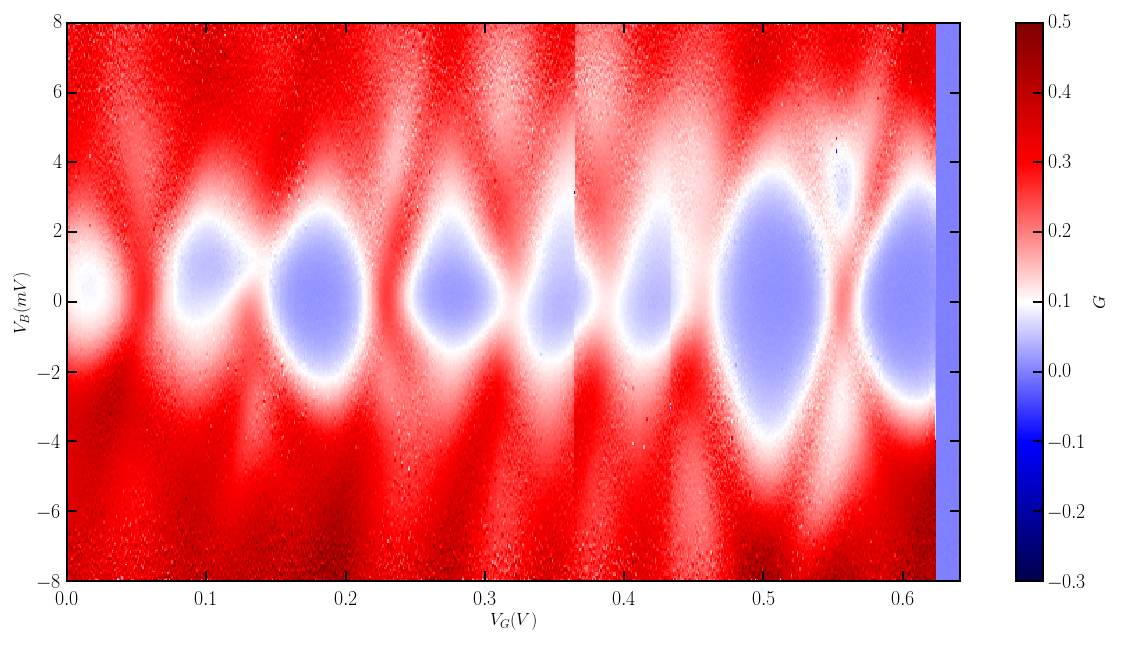

In [561]:
f = 'VI-gate_9-12_13_d.bin'
full = os.path.join(cold_dir, 'VI-gate_9-12_13_d.bin')

data = np.fromfile(full,'>d')
data = data.reshape((-1, data[0]))
data = data.byteswap().newbyteorder()
data = data.transpose() #20254, 20472
df = pd.DataFrame(data[1:, 1:], index=data[1:, 0], columns=data[0, 1:])
df.columns.name = 'Gate'
df.index.name = 'Bias'
df.index = df.index*1000
df = df.groupby(df.index).mean()
#df.to_pickle(os.path.join(pkl_dir, '4K_'+f[:-4]+'.pkl'))
# df.head()

dV = 100e-6
cond = get_dIdV(df,dV)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
limits = lvdt.df_extent(cond)
im = ax.imshow(cond/3.875e-5, extent = limits, 
               cmap = plt.cm.seismic, vmin = -0.3, vmax = 0.5, 
               origin = 'lower', aspect = 'auto', interpolation = 'nearest')
ax.set_xlabel(r'$V_G (V)$')
ax.set_ylabel(r'$V_B (mV)$')
cb = plt.colorbar(im)
cb.set_label(r'$G$')

cond.to_pickle(os.path.join(pkl_dir, '4K_'+f[:-4]+'_cond.pkl'))

In [531]:
# header = lvdt.get_txt(os.path.join(cold_dir, 'VI-gate_15-16_13_e.txt'))
# for h in header:
#     print h

In [562]:
# start = 3; stop = 4; step = 2.5e-3
gate = df.columns.values
# filelist = [os.path.join(cold_dir, 'VI-gate_15-16_13_f_{0:.0f}.bin'.format(round(g*1000,0))) for g in gate]
filelist = glob.glob(os.path.join(cold_dir, 'VI-gate_9-12_13_d_*.bin'))
filelist.sort(key=lambda f: float(f[49:-4]))

In [568]:
os.path.isfile(filelist[0])

True

In [574]:
### get full data set to create empty arrays ###
full_data_set = os.path.join(pkl_dir, '4K_VI-gate_9-12_13_d.pkl')
df = pd.read_pickle(full_data_set)
df = df.groupby(df.index).mean()
ampdf = pd.DataFrame(np.zeros(df.shape), index = df.index, columns = df.columns)

for j, f in enumerate(filelist[:-1]):
    psdf = get_data_ps(f)

    current = psdf['Iavg']
    psdf.drop(psdf.columns[[0, 1]], axis=1, inplace=True) # drop the current and f=0 columns

    #A = np.zeros(len(df.index))
    for i, bias in enumerate(df.index):
        params['current'].value = current[bias] # set current
        result = model.fit(psdf.ix[bias,:], params, x=psdf.columns)
        ampdf.iloc[i,j] = result.params['amp'].value

In [576]:
# ampdf.to_pickle(os.path.join(pkl_dir, '4K_VI-gate_9-12_13_d_noise-amp.pkl'))
# ampdf.head()

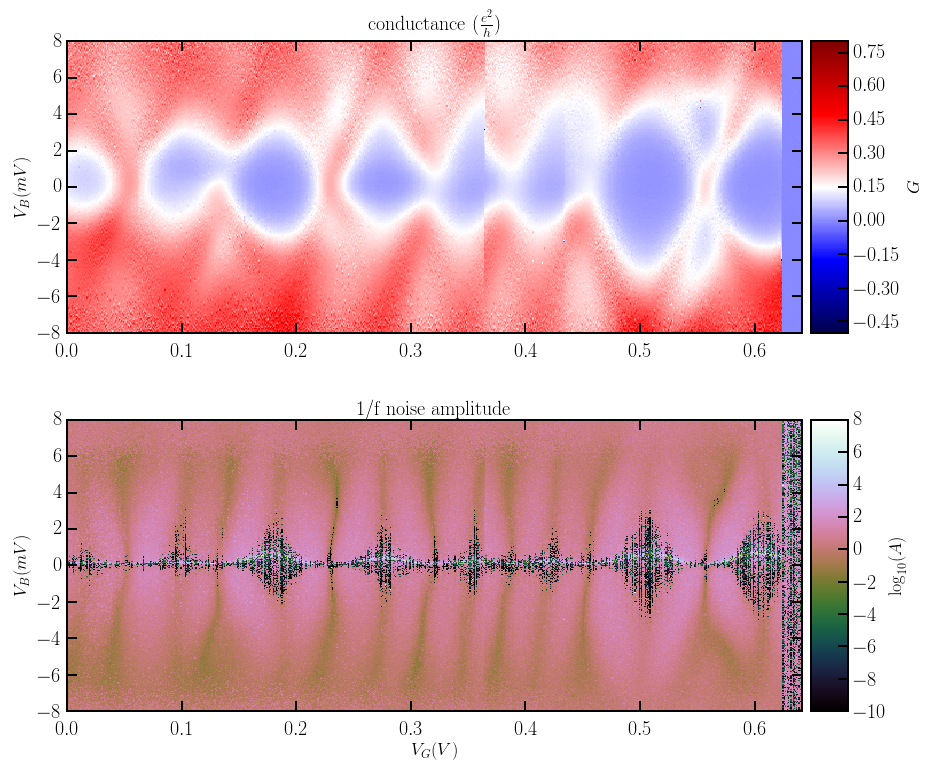

In [577]:
cond = pd.read_pickle(os.path.join(pkl_dir, '4K_VI-gate_9-12_13_d_cond.pkl'))
ampdf = pd.read_pickle(os.path.join(pkl_dir, '4K_VI-gate_9-12_13_d_noise-amp.pkl'))

fig = plt.figure(figsize = (14,12))
gs = gridspec.GridSpec(2, 2, height_ratios=(1, 1), width_ratios=(20, 1))
gs.update(wspace=0.025, hspace=0.3)
axes = fig.add_subplot(gs[0,0])
limits = lvdt.df_extent(ampdf)

im0 = axes.imshow(cond/3.875e-5, extent = limits, 
               cmap = plt.cm.seismic, vmin = -0.5, vmax = 0.8, 
               origin = 'lower', aspect = 'auto', interpolation = 'nearest')
#ax[0].set_xlabel(r'$V_G (V)$')
axes.set_ylabel(r'$V_B (mV)$')
axes.set_title(r'conductance ($\frac{e^2}{h}$)')
cax = fig.add_subplot(gs[0,1])
cb0 = plt.colorbar(im0, cax = cax)
cb0.set_label(r'$G$')

axes = fig.add_subplot(gs[1,0])
im1 = axes.imshow(np.log10(ampdf), extent = limits, 
               cmap = plt.cm.cubehelix, vmin = -10, vmax = 8, 
               origin = 'lower', aspect = 'auto', interpolation = 'nearest')
axes.set_xlabel(r'$V_G (V)$')
axes.set_ylabel(r'$V_B (mV)$')
axes.set_title('1/f noise amplitude')
cax = fig.add_subplot(gs[1,1])
cb1 = plt.colorbar(im1, cax = cax)
cb1.set_label(r'$\log_{10}(A)$')

fig.savefig(os.path.join(fig_dir, '4K_VI-gate_9-112_13_d_cond-noise.pdf'), format='pdf', dpi=300)

# SCF96

In [823]:
pkl_dir = '/Volumes/JUPITER/Data/fm_dots/SCF96/'
fig_dir = '/Volumes/JUPITER/Data/fm_dots/SCF96/figures/'

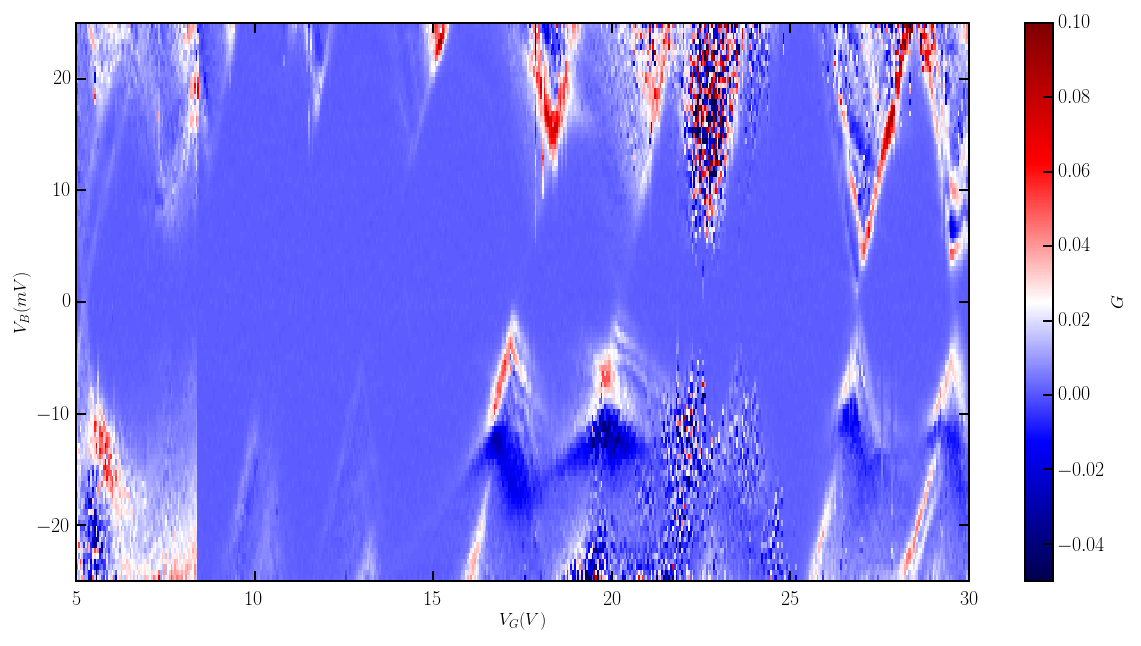

In [645]:
cold_dir = '/Volumes/JUPITER/Data/SCF96/q3/'
f = '4K_vi-gate_16-17_23_a_2T.pkl'
#full = os.path.join(cold_dir, )

df = pd.read_pickle(os.path.join(pkl_dir,f))
#df.index = df.index*1000
#df.to_pickle(os.path.join(pkl_dir, f))
df.head()

dV = 500e-6
cond = get_dIdV(df,dV)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
limits = lvdt.df_extent(cond)
im = ax.imshow(cond/3.875e-5, extent = limits, 
               cmap = plt.cm.seismic, vmin = -0.05, vmax = 0.1, 
               origin = 'lower', aspect = 'auto', interpolation = 'nearest')
ax.set_xlabel(r'$V_G (V)$')
ax.set_ylabel(r'$V_B (mV)$')
cb = plt.colorbar(im)
cb.set_label(r'$G$')

cond.to_pickle(os.path.join(pkl_dir, f[:-4]+'_cond.pkl'))

In [635]:
# start = 3; stop = 4; step = 2.5e-3
gate = df.columns.values
filelist = [os.path.join(cold_dir, 'vi-gate_16-17_23_a_2T_{0:.0f}.bin'.format(round(g*1000,0))) for g in gate]
# filelist = glob.glob(os.path.join(cold_dir, 'vi-gate_9-12_23_f_*.bin'))
#filelist.sort(key=lambda f: float(f[))

In [641]:
### get full data set to create empty arrays ###
full_data_set = os.path.join(pkl_dir, '4K_vi-gate_16-17_23_a_2T.pkl')
df = pd.read_pickle(full_data_set)
df = df.groupby(df.index).mean()
ampdf = pd.DataFrame(np.zeros(df.shape), index = df.index, columns = df.columns)

for j, f in enumerate(filelist):
    psdf = get_data_ps(f)

    current = psdf['Iavg']
    psdf.drop(psdf.columns[[0, 1]], axis=1, inplace=True) # drop the current and f=0 columns

    #A = np.zeros(len(df.index))
    for i, bias in enumerate(df.index):
        params['current'].value = current[bias] # set current
        result = model.fit(psdf.ix[bias,:], params, x=psdf.columns)
        ampdf.iloc[i,j] = result.params['amp'].value

In [643]:
# ampdf.head()
ampdf.to_pickle(os.path.join(pkl_dir, '4K_vi-gate_16-17_23_a_2T_noise-amp.pkl'))

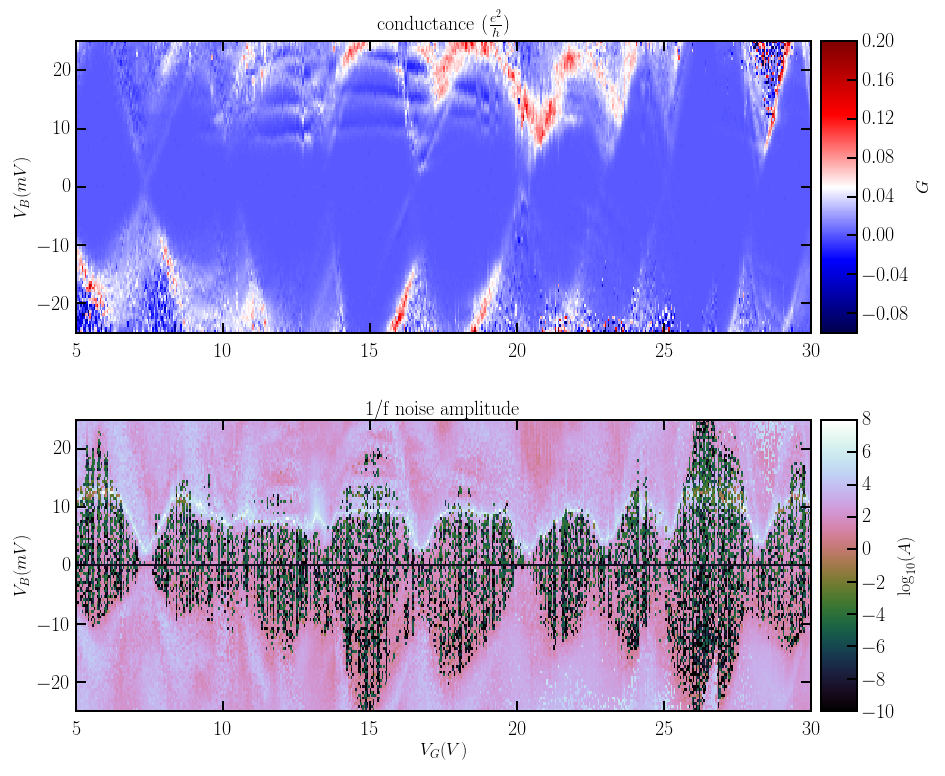

In [648]:
cond = pd.read_pickle(os.path.join(pkl_dir, '4K_vi-gate_16-17_23_a_cond.pkl'))
ampdf = pd.read_pickle(os.path.join(pkl_dir, '4K_vi-gate_16-17_23_a_noise-amp.pkl'))

fig = plt.figure(figsize = (14,12))
gs = gridspec.GridSpec(2, 2, height_ratios=(1, 1), width_ratios=(20, 1))
gs.update(wspace=0.025, hspace=0.3)
axes = fig.add_subplot(gs[0,0])
limits = lvdt.df_extent(ampdf)

im0 = axes.imshow(cond/3.875e-5, extent = limits, 
               cmap = plt.cm.seismic, vmin = -0.1, vmax = 0.2, 
               origin = 'lower', aspect = 'auto', interpolation = 'nearest')
#ax[0].set_xlabel(r'$V_G (V)$')
axes.set_ylabel(r'$V_B (mV)$')
axes.set_title(r'conductance ($\frac{e^2}{h}$)')
cax = fig.add_subplot(gs[0,1])
cb0 = plt.colorbar(im0, cax = cax)
cb0.set_label(r'$G$')

axes = fig.add_subplot(gs[1,0])
im1 = axes.imshow(np.log10(ampdf), extent = limits, 
               cmap = plt.cm.cubehelix, vmin = -10, vmax = 8, 
               origin = 'lower', aspect = 'auto', interpolation = 'nearest')
axes.set_xlabel(r'$V_G (V)$')
axes.set_ylabel(r'$V_B (mV)$')
axes.set_title('1/f noise amplitude')
cax = fig.add_subplot(gs[1,1])
cb1 = plt.colorbar(im1, cax = cax)
cb1.set_label(r'$\log_{10}(A)$')

# fig.savefig(os.path.join(fig_dir, '4K_vi-gate_16-16_23_a_cond-noise.pdf'), format='pdf', dpi=300)

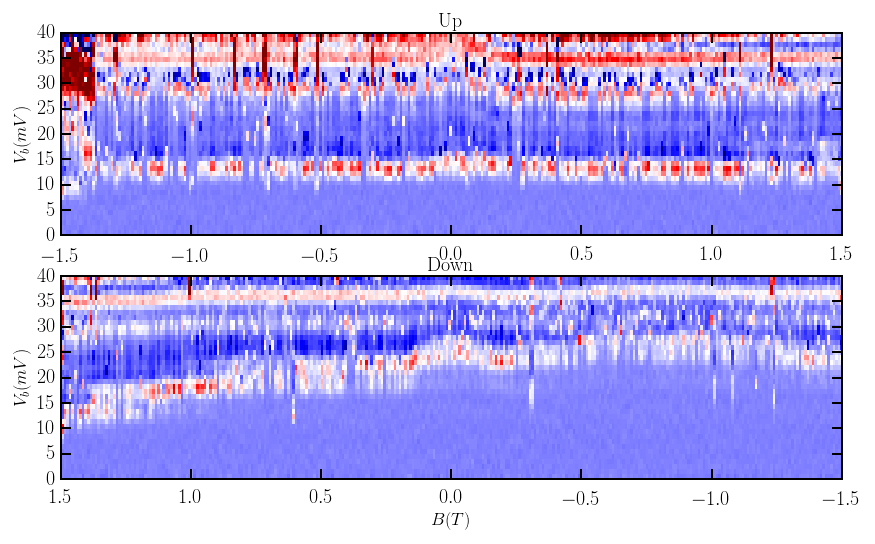

In [666]:
cold_dir = '/Volumes/JUPITER/Data/SCF96/q3/'
f = '4K_vi-bswp_16-17_23_c_10000.0mV.pkl'
df = pd.read_pickle(os.path.join(pkl_dir,f))
# df.head()

dV = 1e-3
cond = get_dIdV(df,dV)

ind = np.where(np.diff(df.columns)==0)[0]
cuts = np.concatenate(([0],ind,[len(df.columns)-1]), axis=0)

fig, ax = plt.subplots(2,1, figsize=(14,8))

limits = [df.columns[cuts[0]], df.columns[cuts[1]], df.index.min(), df.index.max()]
im0 = ax[0].imshow(cond.iloc[:,cuts[0]:cuts[1]]/3.875e-5, extent = limits, 
               cmap = plt.cm.seismic, vmin = -0.01, vmax = 0.02,
               origin = 'lower', aspect = 'auto', interpolation = 'nearest')
#ax[0].set_xlabel(r'$V_g (V)$')
ax[0].set_ylabel(r'$V_b (mV)$')
ax[0].set_title('Up')
#cb0 = plt.colorbar(im0)
#cb0.set_label(r'$I (nA)$')

limits = [df.columns[cuts[1]], df.columns[cuts[-1]], df.index.min(), df.index.max()]
im1 = ax[1].imshow(cond.iloc[:,cuts[1]:cuts[-1]]/3.875e-5, extent = limits, 
               cmap = plt.cm.seismic, vmin = -0.01, vmax = 0.02,
               origin = 'lower', aspect = 'auto', interpolation = 'nearest')
#ax[0].set_xlabel(r'$V_g (V)$')
ax[1].set_ylabel(r'$V_b (mV)$')
ax[1].set_xlabel(r'$B (T)$')
ax[1].set_title('Down')

cond.to_pickle(os.path.join(pkl_dir, f[:-4]+'_cond.pkl'))

In [667]:
# start = 3; stop = 4; step = 2.5e-3
gate = df.columns.values
filelist = [os.path.join(cold_dir, 'vi-bswp_16-17_23_c_{0:.0f}.bin'.format(round(g*1000,0))) for g in gate]
# filelist = glob.glob(os.path.join(cold_dir, 'vi-gate_9-12_23_f_*.bin'))
#filelist.sort(key=lambda f: float(f[))

In [673]:
reload(lvdt)

<module 'lvdatatools' from '/Users/nik/Dropbox/Repos/lvdatatools/lvdatatools.py'>

In [676]:
### get full data set to create empty arrays ###
full_data_set = os.path.join(pkl_dir, '4K_vi-bswp_16-17_23_c_10000.0mV.pkl')
df = pd.read_pickle(full_data_set)
df = df.groupby(df.index).mean()
ampdf = pd.DataFrame(np.zeros(df.shape), index = df.index, columns = df.columns)

for j, f in enumerate(filelist):
    psdf = get_data_ps(f)

    current = psdf['Iavg']
    psdf.drop(psdf.columns[[0, 1]], axis=1, inplace=True) # drop the current and f=0 columns

    #A = np.zeros(len(df.index))
    for i, bias in enumerate(df.index):
        params['current'].value = current[bias] # set current
        result = model.fit(psdf.ix[bias,:], params, x=psdf.columns)
        ampdf.iloc[i,j] = result.params['amp'].value

In [678]:
ampdf.to_pickle(os.path.join(pkl_dir, '4K_vi-bswp_16-17_23_c_10000.0mV_noise-amp.pkl'))

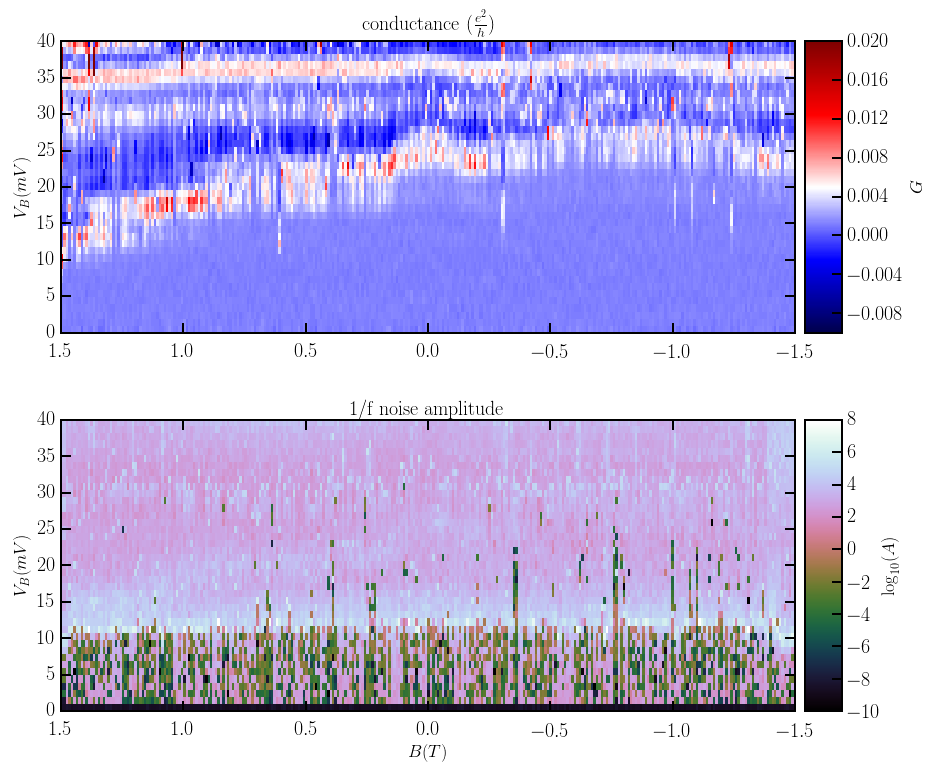

In [834]:
cond = pd.read_pickle(os.path.join(pkl_dir, '4K_vi-bswp_16-17_23_c_10000.0mV_cond.pkl'))
ampdf = pd.read_pickle(os.path.join(pkl_dir, '4K_vi-bswp_16-17_23_c_10000.0mV_noise-amp.pkl'))

ind = np.where(np.diff(cond.columns)==0)[0]
cuts = np.concatenate(([0],ind,[len(cond.columns)-1]), axis=0)
limits = [cond.columns[cuts[1]], cond.columns[cuts[-1]], cond.index.min(), cond.index.max()]

fig = plt.figure(figsize = (14,12))
gs = gridspec.GridSpec(2, 2, height_ratios=(1, 1), width_ratios=(20, 1))
gs.update(wspace=0.025, hspace=0.3)
axes = fig.add_subplot(gs[0,0])

im0 = axes.imshow(cond.iloc[:,cuts[1]:cuts[-1]]/3.875e-5, extent = limits, 
               cmap = plt.cm.seismic, vmin = -0.01, vmax = 0.02, 
               origin = 'lower', aspect = 'auto', interpolation = 'nearest')
#ax[0].set_xlabel(r'$V_G (V)$')
axes.set_ylabel(r'$V_B (mV)$')
axes.set_title(r'conductance ($\frac{e^2}{h}$)')
cax = fig.add_subplot(gs[0,1])
cb0 = plt.colorbar(im0, cax = cax)
cb0.set_label(r'$G$')

axes = fig.add_subplot(gs[1,0])
im1 = axes.imshow(np.log10(ampdf.iloc[:,cuts[1]:cuts[-1]]), extent = limits, 
               cmap = plt.cm.cubehelix, vmin = -10, vmax = 8, 
               origin = 'lower', aspect = 'auto', interpolation = 'nearest')
axes.set_xlabel(r'$B (T)$')
axes.set_ylabel(r'$V_B (mV)$')
axes.set_title('1/f noise amplitude')
cax = fig.add_subplot(gs[1,1])
cb1 = plt.colorbar(im1, cax = cax)
cb1.set_label(r'$\log_{10}(A)$')

fig.savefig(os.path.join(fig_dir, '4K_vi-bswp_16-17_23_c_10000.0mV_cond-noise_downswp.pdf'), format='pdf', dpi=300)

#SCF98

In [685]:
pkl_dir = '/Volumes/JUPITER/Data/fm_dots/SCF98/'
fig_dir = '/Volumes/JUPITER/Data/fm_dots/SCF98/figures/'
cold_dir = '/Volumes/JUPITER/Data/SCF98/q2/500mK/'

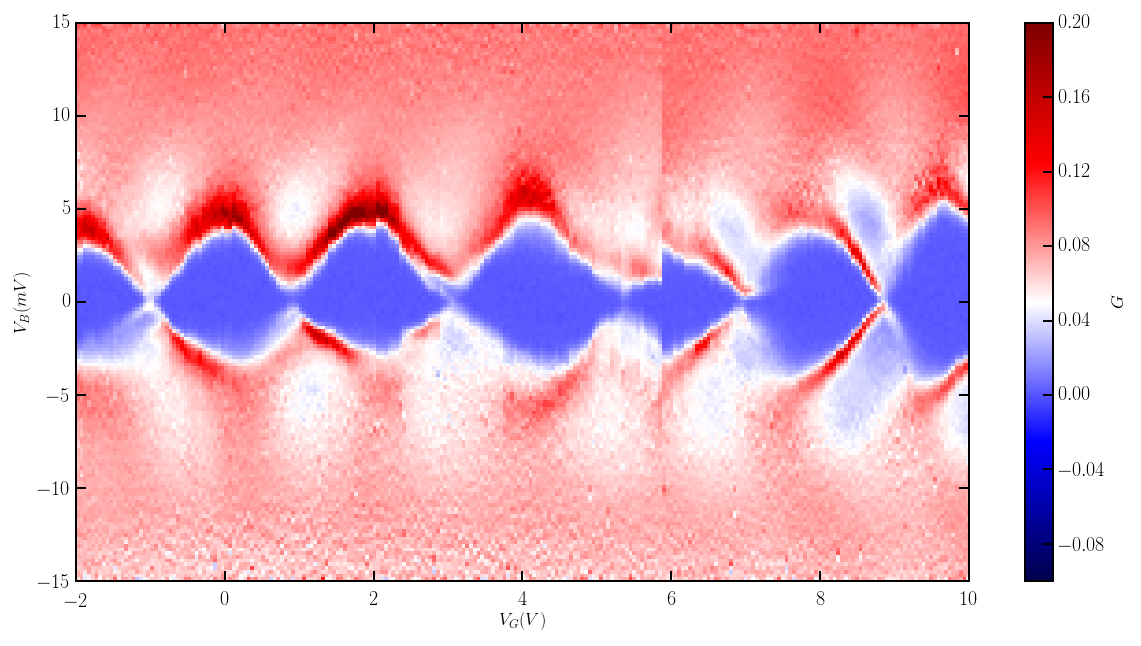

In [690]:
f = '500mK_vi-gate_11-12_23_c.pkl'

df = pd.read_pickle(os.path.join(pkl_dir,f))
df.index = df.index*1000
# df.to_pickle(os.path.join(pkl_dir, f))
df.head()

dV = 200e-6
cond = get_dIdV(df,dV)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
limits = lvdt.df_extent(cond)
im = ax.imshow(cond/3.875e-5, extent = limits, 
               cmap = plt.cm.seismic, vmin = -0.1, vmax = 0.2, 
               origin = 'lower', aspect = 'auto', interpolation = 'nearest')
ax.set_xlabel(r'$V_G (V)$')
ax.set_ylabel(r'$V_B (mV)$')
cb = plt.colorbar(im)
cb.set_label(r'$G$')

cond.to_pickle(os.path.join(pkl_dir, f[:-4]+'_cond.pkl'))

In [691]:
# start = 3; stop = 4; step = 2.5e-3
gate = df.columns.values
filelist = [os.path.join(cold_dir, 'vi-gate_11-12_23_c_{0:.0f}.bin'.format(round(g*1000,0))) for g in gate]
# filelist = glob.glob(os.path.join(cold_dir, 'vi-gate_9-12_23_f_*.bin'))
#filelist.sort(key=lambda f: float(f[))

In [695]:
for h in lvdt.get_txt(os.path.join(cold_dir, 'vi-gate_11-12_23_c.bin')):
    print h

['bias:gate', '']
['Voltage Input Setup', ' ']
['Samples to Read', ' 2.20500E+4']
['Input Channel 1', ' Dev1/ai0']
['Sample Rate', ' 4.41000E+4']
['Input Minimum Value', ' -5.00000E+0']
['Input Maximum Value', ' 5.00000E+0']
['Terminal Configuration', ' Differential']
['Name', ' Measure']
['Sample Mode', ' Finite Samples']
['', '']
['Gate Sweep', ' ']
['Start (V)', ' -2.00000E+0']
['Stop (V)', ' 1.00000E+1']
['Step (V)', ' 5.00000E-2']
['Divider', ' 1.00000E+0']
['Physical Channel', ' Dev1/ao3']
['Name', ' Gate']
['Minimum Value', ' -1.00000E+1']
['Maximum Value', ' 1.00000E+1']
['Sweep Type', ' One Way']
['Runs', ' 1.00000E+0']
['', '']
['Bias Sweep', ' ']
['Start (V)', ' -1.50000E-2']
['Stop (V)', ' 1.50000E-2']
['Step (V)', ' 2.00000E-4']
['Divider', ' 1.00000E-2']
['Physical Channel', ' Dev1/ao0']
['Name', ' Bias']
['Minimum Value', ' -2.00000E+0']
['Maximum Value', ' 2.00000E+0']
['Sweep Type', ' There and Back']
['Runs', ' 1.00000E+0']
['', '']
['Other', ' ']
['Current Amp', ' -1

This is the only data file that might have enough information to make a shot noise plot. Plot a few S vs f data sets and try to figure out where the cutoffs for the relevant regions are.

For whatever reason, the 1/f noise covers the whole frequency range from 1 to 22kHz. Sooooooo... i'm going to cut it off at 6kHz because of a strange peak, and, again, just plot the 1/f noise.

In [815]:
### get full data set to create empty arrays ###
full_data_set = os.path.join(pkl_dir, '500mK_vi-gate_11-12_23_c.pkl')
df = pd.read_pickle(full_data_set)
df = df.groupby(df.index).mean()
ampdf = pd.DataFrame(np.zeros(df.shape), index = df.index, columns = df.columns)

for j, f in enumerate(filelist):
    psdf = get_data_ps(f)

    current = psdf['Iavg']
    psdf.drop(psdf.columns[[0, 1]], axis=1, inplace=True) # drop the current and f=0 columns
    psdf = psdf.loc[:,psdf.columns.values < 6e3]
    #A = np.zeros(len(df.index))
    for i, bias in enumerate(df.index):
        params['current'].value = current[bias] # set current
        result = model.fit(psdf.ix[bias,:], params, x=psdf.columns)
        ampdf.iloc[i,j] = result.params['amp'].value

In [817]:
ampdf.to_pickle(os.path.join(pkl_dir, '500mK_vi-gate_11-12_23_c_noise-amp.pkl'))

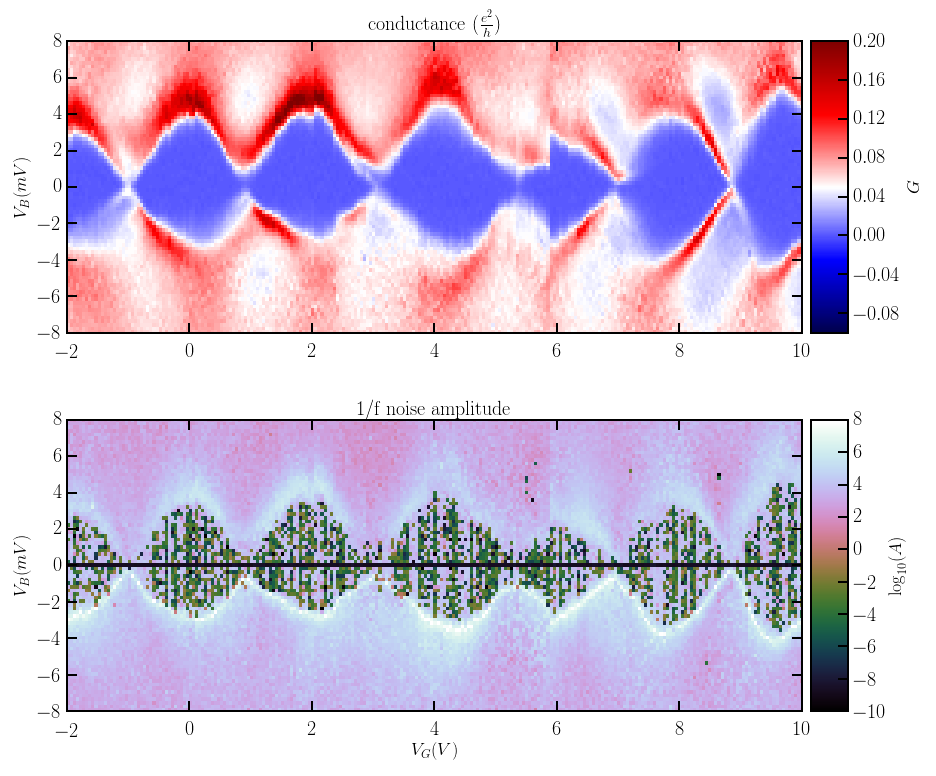

In [821]:
cond = pd.read_pickle(os.path.join(pkl_dir, '500mK_vi-gate_11-12_23_c_cond.pkl'))
ampdf = pd.read_pickle(os.path.join(pkl_dir, '500mK_vi-gate_11-12_23_c_noise-amp.pkl'))

fig = plt.figure(figsize = (14,12))
gs = gridspec.GridSpec(2, 2, height_ratios=(1, 1), width_ratios=(20, 1))
gs.update(wspace=0.025, hspace=0.3)
axes = fig.add_subplot(gs[0,0])
limits = lvdt.df_extent(ampdf)

im0 = axes.imshow(cond/3.875e-5, extent = limits, 
               cmap = plt.cm.seismic, vmin = -0.1, vmax = 0.2, 
               origin = 'lower', aspect = 'auto', interpolation = 'nearest')
#ax[0].set_xlabel(r'$V_G (V)$')
axes.set_ylabel(r'$V_B (mV)$')
axes.set_title(r'conductance ($\frac{e^2}{h}$)')
axes.set_ylim(-8, 8)
cax = fig.add_subplot(gs[0,1])
cb0 = plt.colorbar(im0, cax = cax)
cb0.set_label(r'$G$')

axes = fig.add_subplot(gs[1,0])
im1 = axes.imshow(np.log10(ampdf), extent = limits, 
               cmap = plt.cm.cubehelix, vmin = -10, vmax = 8, 
               origin = 'lower', aspect = 'auto', interpolation = 'nearest')
axes.set_xlabel(r'$V_G (V)$')
axes.set_ylabel(r'$V_B (mV)$')
axes.set_title('1/f noise amplitude')
axes.set_ylim(-8, 8)
cax = fig.add_subplot(gs[1,1])
cb1 = plt.colorbar(im1, cax = cax)
cb1.set_label(r'$\log_{10}(A)$')

fig.savefig(os.path.join(fig_dir, '500mK_vi-gate_11-12_23_c_cond-noise.pdf'), format='pdf', dpi=300)